## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('cache/planet/tmp', exist_ok=True)

!ln -s ~/datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s ~/datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s ~/datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
!ln -s ~/cache/planet/tmp {PATH}

ln: failed to create symbolic link 'data/planet/train-jpg': File exists
ln: failed to create symbolic link 'data/planet/train_v2.csv': File exists
ln: failed to create symbolic link 'data/planet/test-jpg': File exists
ln: failed to create symbolic link 'data/planet/tmp': File exists


In [5]:
ls {PATH}

models/  test-jpg@  tmp@  train-jpg@  train_v2.csv@


## Multi-label versus single-label classification

In [6]:
from fastai.plots import *

In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

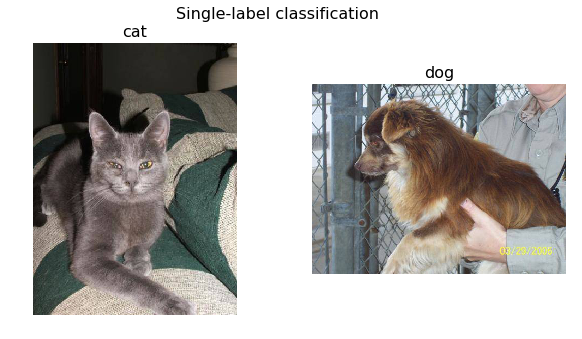

In [8]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

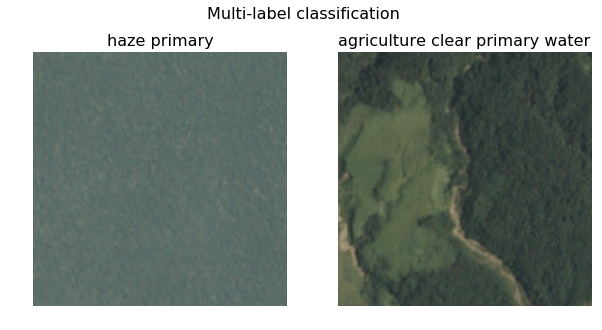

In [9]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [ ]:
from planet import f2

metrics=[f2]
f_model = resnet34


In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [12]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [13]:
data = get_data(256)

In [41]:
x,y = next(iter(data.val_dl))

In [42]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [52]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

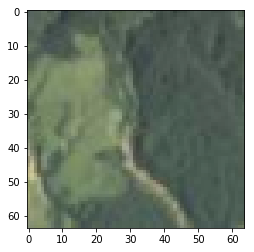

In [53]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [54]:
sz=64

In [55]:
data = get_data(sz)

In [56]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [57]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 315/506 [00:08<00:05, 35.20it/s, loss=0.539]

Exception in thread Thread-60:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/michael/Development/venv/fastai36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/michael/Development/venv/fastai36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   f2                          
    0      0.227417   0.352885   0.802387  



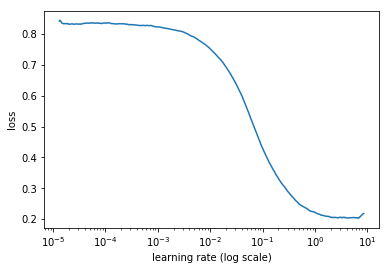

In [58]:
lrf=learn.lr_find()
learn.sched.plot()

In [59]:
lr = 0.2

In [60]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.147073   0.135083   0.880487  
    1      0.14143    0.129492   0.887821                    
    2      0.141753   0.127324   0.888373                    
    3      0.137666   0.126716   0.890498                    
    4      0.134876   0.12452    0.891412                    
    5      0.133384   0.12312    0.893356                    
    6      0.131614   0.122911   0.893145                    



[0.12291073, 0.8931451813489989]

In [61]:
lrs = np.array([lr/9,lr/3,lr])

In [62]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.121676   0.109921   0.907581  
    1      0.114536   0.105785   0.907915                    
    2      0.109423   0.101942   0.914                       
    3      0.112582   0.103483   0.912259                    
    4      0.106158   0.09938    0.917261                    
    5      0.100741   0.098011   0.917132                     
    6      0.099591   0.097422   0.917487                     



[0.09742207, 0.9174867606395455]

In [28]:
learn.save(f'{sz}')

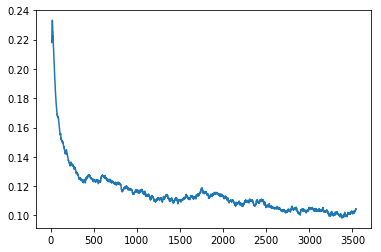

In [29]:
learn.sched.plot_loss()

In [30]:
sz=128

In [31]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.100053   0.097901   0.916064  
    1      0.10041    0.096904   0.916451                     
    2      0.100468   0.095815   0.917733                     
    3      0.101891   0.095296   0.919411                     
    4      0.095627   0.09411    0.920647                     
    5      0.096584   0.093865   0.919989                     
    6      0.097387   0.093872   0.920412                     


[0.09387158, 0.9204116994887853]

In [32]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.095994   0.088823   0.926088  
    1      0.093018   0.088708   0.927361                     
    2      0.090516   0.087086   0.927478                     
    3      0.093417   0.089159   0.926334                     
    4      0.089741   0.088056   0.924995                     
    5      0.086708   0.085916   0.928192                     
    6      0.087348   0.085436   0.928648                     


In [33]:
sz=256

In [34]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.091251   0.089875   0.924562  
    1      0.09095    0.089028   0.925409                     
    2      0.089618   0.088777   0.925193                     
    3      0.09155    0.088867   0.925044                     
    4      0.091763   0.088673   0.925041                     
    5      0.092076   0.088096   0.925414                     
    6      0.089477   0.087742   0.926151                     


[0.08774216, 0.9261507922255395]

In [35]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.08691    0.084241   0.929557  
    1      0.088981   0.083929   0.930108                     
    2      0.085867   0.082869   0.93143                      
    3      0.088197   0.084048   0.930883                     
    4      0.085419   0.082767   0.93091                      
    5      0.080403   0.08175    0.931881                     
    6      0.080434   0.081901   0.932802                     


In [36]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [37]:
f2(preds,y)

0.9305084231301096

### End